In [1]:

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (11, 6)

In [2]:
def load_and_merge():
    with open("../traces_CA_final/traces_CA_final.json", 'r', encoding='utf-8') as f:
        data_nf = json.load(f)
    with open("../traces_CA/traces_CA.json", 'r', encoding='utf-8') as f:
        data_forced = json.load(f)

    df_nf = pd.DataFrame(data_nf)
    df_forced = pd.DataFrame(data_forced)

    # cols we analyze
    cols_interest = ['question_id', 'difficulty', 'execution_accuracy', 'pred_query',
                     'latency', 'tool_call_count', 'error_count', 'reasoning_len']
    
    nf_cols = [c for c in cols_interest if c in df_nf.columns]
    forced_cols = [c for c in cols_interest if c in df_forced.columns]

    df_nf = df_nf[nf_cols].add_suffix('_nf')
    df_forced = df_forced[forced_cols].add_suffix('_forced')

    df_nf = df_nf.rename(columns={'question_id_nf': 'question_id'})
    df_forced = df_forced.rename(columns={'question_id_forced': 'question_id'})

    # Merge on question_id
    merged_df = pd.merge(df_nf, df_forced, on='question_id', how='inner')
    
    # Normalize Difficulty (Use the one from NF, lowercase it)
    if 'difficulty_nf' in merged_df.columns:
        merged_df['difficulty'] = merged_df['difficulty_nf'].astype(str).str.lower().str.strip()
        merged_df.drop(columns=['difficulty_nf', 'difficulty_forced'], inplace=True, errors='ignore')

    return merged_df

df = load_and_merge()


Global Accuracy (NF):     58.99%
Global Accuracy (Forced): 55.64%


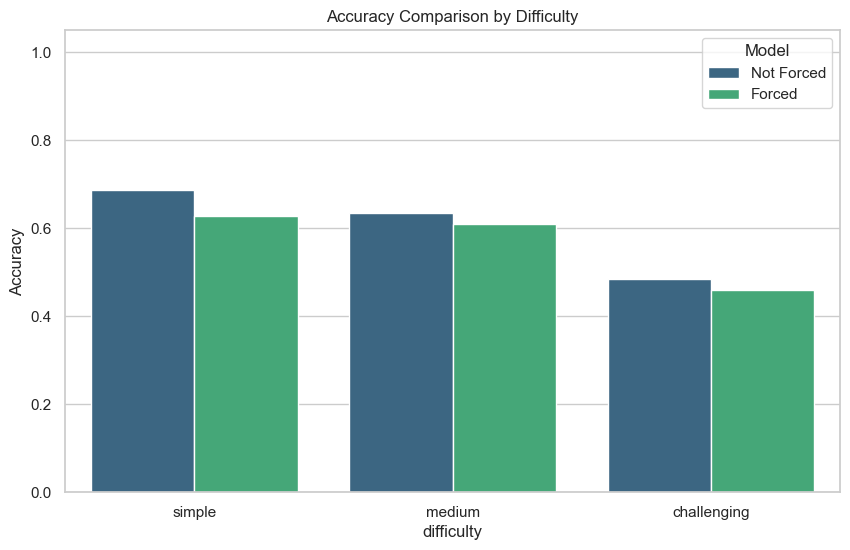

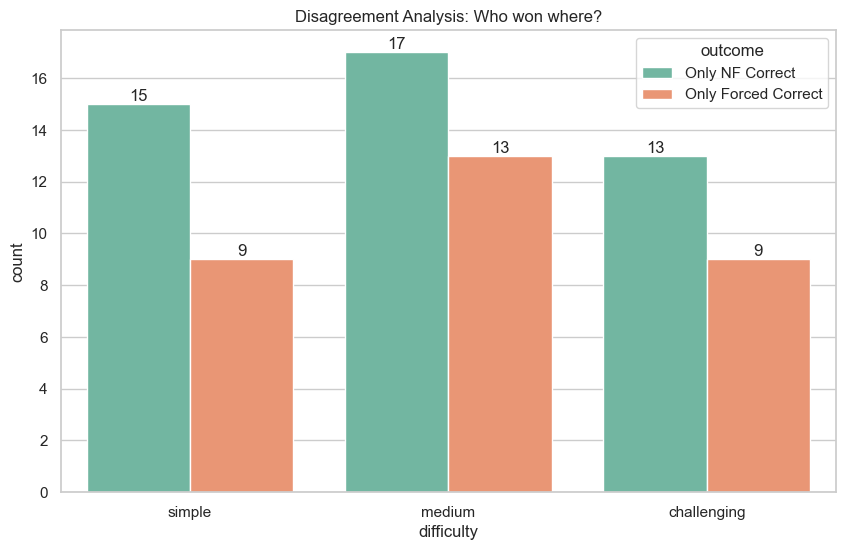

In [3]:

df['is_correct_nf'] = df['execution_accuracy_nf'] == 1
df['is_correct_forced'] = df['execution_accuracy_forced'] == 1

def classify(row):
    if row['is_correct_nf'] and row['is_correct_forced']: return 'Both Correct'
    elif not row['is_correct_nf'] and not row['is_correct_forced']: return 'Both Wrong'
    elif row['is_correct_nf'] and not row['is_correct_forced']: return 'Only NF Correct'
    elif not row['is_correct_nf'] and row['is_correct_forced']: return 'Only Forced Correct'
    return 'Unknown'

df['outcome'] = df.apply(classify, axis=1)

print(f"Global Accuracy (NF):     {df['execution_accuracy_nf'].mean()*100:.2f}%")
print(f"Global Accuracy (Forced): {df['execution_accuracy_forced'].mean()*100:.2f}%")

diff_order = ['simple', 'medium', 'challenging']
melted = df.melt(
    id_vars=['difficulty'], 
    value_vars=['execution_accuracy_nf', 'execution_accuracy_forced'],
    var_name='Model', value_name='Accuracy'
)
melted['Model'] = melted['Model'].replace({'execution_accuracy_nf': 'Not Forced', 'execution_accuracy_forced': 'Forced'})

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='difficulty', y='Accuracy', hue='Model', 
            order=diff_order, palette="viridis", errorbar=None)
plt.title("Accuracy Comparison by Difficulty")
plt.ylim(0, 1.05)
plt.show()

# Disagreement Analysis
disagreements = df[df['outcome'].isin(['Only NF Correct', 'Only Forced Correct'])]
if not disagreements.empty:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=disagreements, x='difficulty', hue='outcome', 
                        order=diff_order, palette="Set2")
    plt.title("Disagreement Analysis: Who won where?")
    for container in ax.containers: ax.bar_label(container)
    plt.show()

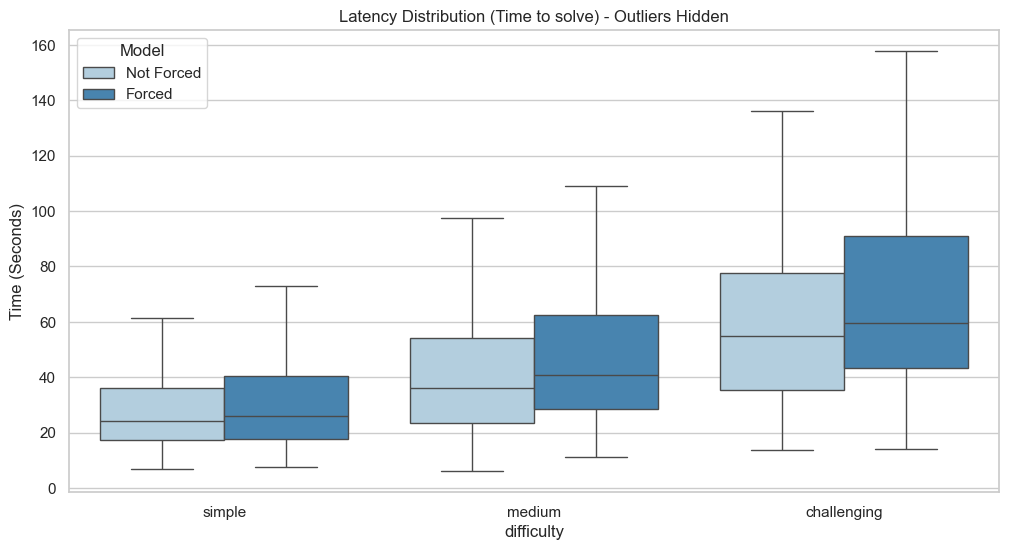

Average Latency (Seconds):
             latency_nf  latency_forced
difficulty                             
simple        30.253922       32.914020
medium        44.593974       52.400064
challenging   63.635346       75.272579


In [4]:
melted_lat = df.melt(
    id_vars=['difficulty'], 
    value_vars=['latency_nf', 'latency_forced'],
    var_name='Model', value_name='Seconds'
)
melted_lat['Model'] = melted_lat['Model'].replace({'latency_nf': 'Not Forced', 'latency_forced': 'Forced'})

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_lat, x='difficulty', y='Seconds', hue='Model', 
            order=diff_order, palette="Blues", showfliers=False) 
plt.title("Latency Distribution (Time to solve) - Outliers Hidden")
plt.ylabel("Time (Seconds)")
plt.show()

print("Average Latency (Seconds):")
print(df.groupby('difficulty')[['latency_nf', 'latency_forced']].mean().reindex(diff_order))

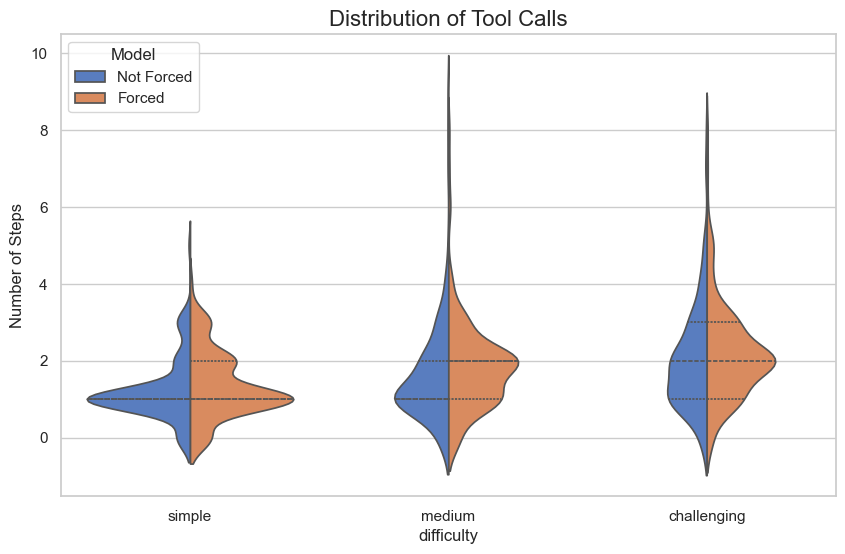

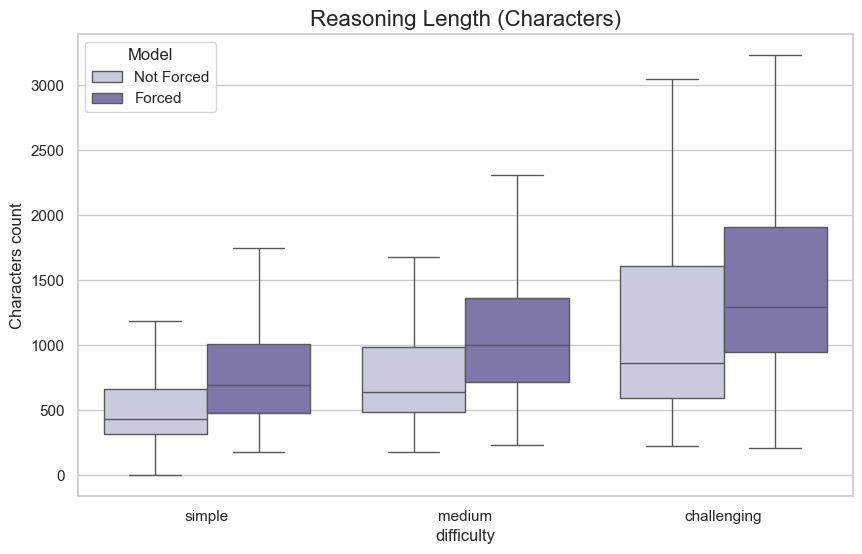

In [5]:
melted_tools = df.melt(
    id_vars=['difficulty'], 
    value_vars=['tool_call_count_nf', 'tool_call_count_forced'],
    var_name='Model', value_name='Steps'
)
melted_tools['Model'] = melted_tools['Model'].replace({'tool_call_count_nf': 'Not Forced', 'tool_call_count_forced': 'Forced'})

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=melted_tools, 
    x='difficulty', 
    y='Steps', 
    hue='Model', 
    split=True, 
    inner="quart", 
    order=diff_order, 
    palette="muted"
)
plt.title("Distribution of Tool Calls", fontsize=16)
plt.ylabel("Number of Steps")
plt.show()

melted_len = df.melt(
    id_vars=['difficulty'], 
    value_vars=['reasoning_len_nf', 'reasoning_len_forced'],
    var_name='Model', value_name='Chars'
)
melted_len['Model'] = melted_len['Model'].replace({'reasoning_len_nf': 'Not Forced', 'reasoning_len_forced': 'Forced'})

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=melted_len, 
    x='difficulty', 
    y='Chars', 
    hue='Model', 
    order=diff_order, 
    palette="Purples", 
    showfliers=False
)
plt.title("Reasoning Length (Characters)", fontsize=16)
plt.ylabel("Characters count")
plt.show()

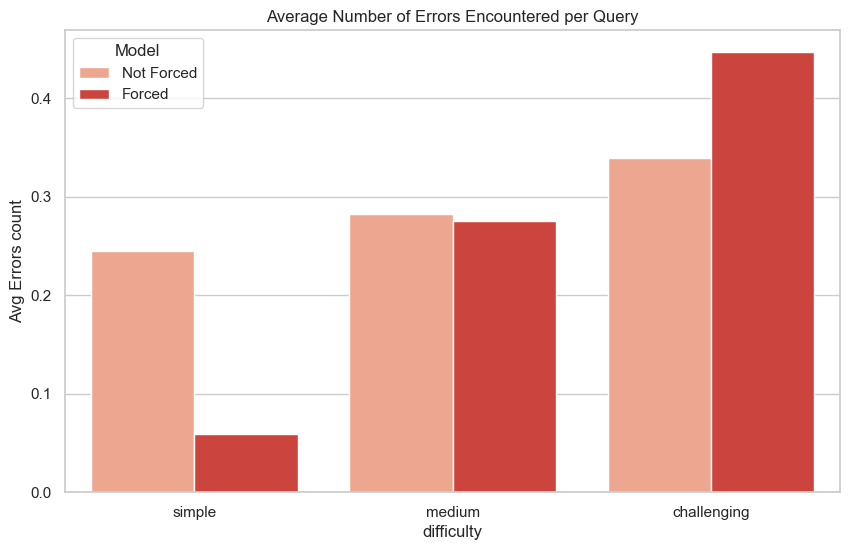

In [6]:
avg_errors = df.groupby('difficulty')[['error_count_nf', 'error_count_forced']].mean().reset_index()

melted_err = avg_errors.melt(
    id_vars='difficulty', 
    var_name='Model', value_name='Avg_Errors'
)
melted_err['Model'] = melted_err['Model'].replace({'error_count_nf': 'Not Forced', 'error_count_forced': 'Forced'})

plt.figure(figsize=(10, 6))
sns.barplot(data=melted_err, x='difficulty', y='Avg_Errors', hue='Model', 
            order=diff_order, palette="Reds")
plt.title("Average Number of Errors Encountered per Query")
plt.ylabel("Avg Errors count")
plt.show()

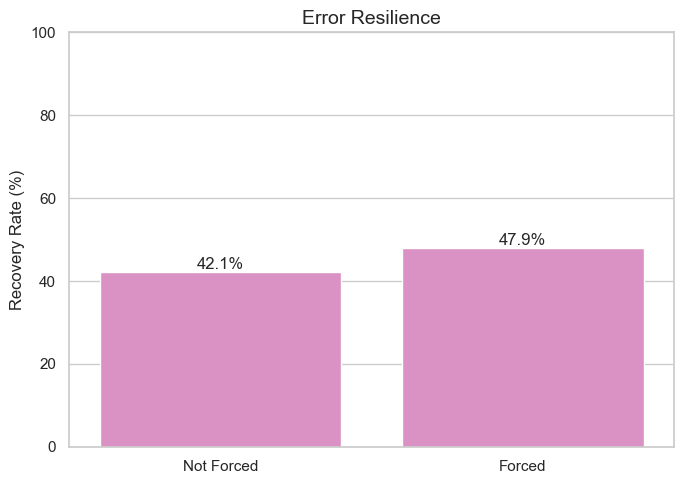

In [7]:
nf_with_errors = df[df['error_count_nf'] > 0]
forced_with_errors = df[df['error_count_forced'] > 0]

# Compute recovery rates
recovery_rate_nf = nf_with_errors['execution_accuracy_nf'].mean() * 100 if not nf_with_errors.empty else 0
recovery_rate_forced = forced_with_errors['execution_accuracy_forced'].mean() * 100 if not forced_with_errors.empty else 0

resilience_data = pd.DataFrame({
    'Model': ['Not Forced', 'Forced'],
    'Recovery Rate (%)': [recovery_rate_nf, recovery_rate_forced]
})

plt.figure(figsize=(7, 5))
ax = sns.barplot(
    data=resilience_data,
    x='Model',
    y='Recovery Rate (%)',
    color="#e685c7"
)

plt.title("Error Resilience", fontsize=14)
plt.ylim(0, 100)
plt.ylabel("Recovery Rate (%)")
plt.xlabel("")

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.tight_layout()
plt.show()